## ENSO forecast

In [1]:
# import necessary libraries
from netCDF4 import Dataset
from sklearn.decomposition import PCA
import sklearn as sk
import numpy as np
from datetime import date
%matplotlib inline
import matplotlib.pyplot as plt
import theano.tensor as T
import pymc3 as pm

In [2]:
# load the data
fname = '/home/yl13414/wrf3/DATA/HadISST/HadISST_sst.nc'
f = Dataset(fname, 'r')
lon = f.variables['longitude'][:]
lat = f.variables['latitude'][:]
tim = f.variables['time']
sst = f.variables['sst'][:]
tim0= date(1951, 1, 1) - date(1870, 1, 1)
tim1= date(1971, 1, 1) - date(1870, 1, 1)
tim2= date(2000,12,31) - date(1870, 1, 1)
tim3= date(2015,12,31) - date(1870, 1, 1)
lon[lon[:]<0] = 360.+lon[lon[:]<0]
dum = np.copy(lon)
lon[:180] = dum[180:]
lon[180:] = dum[:180]
dum = np.copy(sst)
sst[:,:,:180] = dum[:,:,180:]
sst[:,:,180:] = dum[:,:,:180]

In [3]:
# compute the anomalies, the climatology is 1971-2000
sst05 = sst[[k for k in range(len(tim[:])) if tim1.days<=tim[k]<=tim2.days], np.where(lat<5)[0][0]:np.where(lat>-5)[0][-1], 150:260]
sst10 = sst[[k for k in range(len(tim[:])) if tim1.days<=tim[k]<=tim2.days], np.where(lat<10)[0][0]:np.where(lat>-10)[0][-1], 150:260]
sst20 = sst[[k for k in range(len(tim[:])) if tim1.days<=tim[k]<=tim2.days], np.where(lat<20)[0][0]:np.where(lat>-20)[0][-1], 150:260]
sst30 = sst[[k for k in range(len(tim[:])) if tim1.days<=tim[k]<=tim2.days], np.where(lat<30)[0][0]:np.where(lat>-30)[0][-1], 150:260]
sst_nino = sst[[k for k in range(len(tim[:])) if tim1.days<=tim[k]<=tim2.days], np.where(lat<5)[0][0]:np.where(lat>-5)[0][-1], 210:270]

nt, nx, ny = sst20.shape
avg05 = np.array([np.mean(sst05[i+np.array([j*12 for j in range(int(nt/12))]),:,:], axis=0) for i in range(12)])
avg10 = np.array([np.mean(sst10[i+np.array([j*12 for j in range(int(nt/12))]),:,:], axis=0) for i in range(12)])
avg20 = np.array([np.mean(sst20[i+np.array([j*12 for j in range(int(nt/12))]),:,:], axis=0) for i in range(12)])
avg30 = np.array([np.mean(sst30[i+np.array([j*12 for j in range(int(nt/12))]),:,:], axis=0) for i in range(12)])
avg_nino = np.array([np.mean(sst_nino[i+np.array([j*12 for j in range(int(nt/12))]),:,:], axis=0) for i in range(12)])


sst05 = sst[[k for k in range(len(tim[:])) if tim0.days<=tim[k]<=tim2.days], np.where(lat<5)[0][0]:np.where(lat>-5)[0][-1], 150:260]
sst10 = sst[[k for k in range(len(tim[:])) if tim0.days<=tim[k]<=tim2.days], np.where(lat<10)[0][0]:np.where(lat>-10)[0][-1], 150:260]
sst20 = sst[[k for k in range(len(tim[:])) if tim0.days<=tim[k]<=tim2.days], np.where(lat<20)[0][0]:np.where(lat>-20)[0][-1], 150:260]
sst30 = sst[[k for k in range(len(tim[:])) if tim0.days<=tim[k]<=tim2.days], np.where(lat<30)[0][0]:np.where(lat>-30)[0][-1], 150:260]
sst_nino = sst[[k for k in range(len(tim[:])) if tim0.days<=tim[k]<=tim2.days], np.where(lat<5)[0][0]:np.where(lat>-5)[0][-1], 210:270]
nt, nx, ny = sst20.shape

anom05 = np.array([sst05[i,:,:] - avg05[i%12,:,:] for i in range(nt)])
anom10 = np.array([sst10[i,:,:] - avg10[i%12,:,:] for i in range(nt)])
anom20 = np.array([sst20[i,:,:] - avg20[i%12,:,:] for i in range(nt)])
anom30 = np.array([sst30[i,:,:] - avg30[i%12,:,:] for i in range(nt)])
anom_nino = np.array([sst_nino[i,:,:] - avg_nino[i%12,:,:] for i in range(nt)])


anom05[anom05>10.] = 0. #np.nan
anom05[anom05<-10.] = 0. #np.nan
anom10[anom10>10.] = 0. #np.nan
anom10[anom10<-10.] = 0. #np.nan
anom20[anom20>10.] = 0. #np.nan
anom20[anom20<-10.] = 0. #np.nan
anom30[anom30>10.] = 0. #np.nan
anom30[anom30<-10.] = 0. #np.nan
anom_nino[anom_nino>10.] = 0. #np.nan
anom_nino[anom_nino<-10.] = 0. #np.nan
nino = np.nanmean(np.nanmean(anom_nino, axis=1), axis=1)

In [4]:
# test data, 2001-2015
nt = 180
sst_nino = sst[[k for k in range(len(tim[:])) if tim2.days<=tim[k]<=tim3.days], np.where(lat<5)[0][0]:np.where(lat>-5)[0][-1], 210:270]
anom_nino = np.array([sst_nino[i,:,:] - avg_nino[i%12,:,:] for i in range(nt)])
nino_test = np.nanmean(np.nanmean(anom_nino, axis=1), axis=1)


In [5]:
# EOF decomposition for sst20
nt, ny, nx = sst20.shape
nEOF = 10
pca = PCA(n_components=nEOF, svd_solver='full')
pca.fit(anom20.reshape([nt, nx*ny]).T)
EOF1 = -pca.components_[0,:]
#pca.fit(anom05[:,5,:].T)

In [6]:
LR = sk.linear_model.LinearRegression()
x_train = EOF1[2+np.array([j*12 for j in range(int(nt/12))])]
y_train = EOF1[3+np.array([j*12 for j in range(int(nt/12))])]
#x_train = EOF1[:-3]
#y_train = EOF1[3:]
LR.fit(x_train.reshape(-1,1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

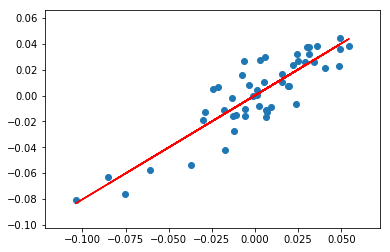

In [7]:
plt.scatter(x_train, y_train)
plt.plot(x_train,LR.coef_*x_train+LR.intercept_,'r')

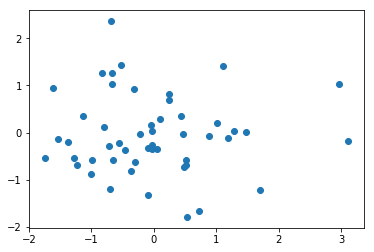

In [8]:
plt.scatter(nino[np.array([j*12 for j in range(int(nt/12))])],nino[6+np.array([j*12 for j in range(int(nt/12))])])

In [9]:
# Here I assume sst changes randomly ~N(0.,sigma)
#def delta_sst():

### Linear Regression

I run a linear regression here to carry a 3-month prediction. The learning window is 7 years (just because the period of ENSO is 2~7 years)

In [23]:
# test case with just nino index
k = 1 #7*12
nt, ny, nx = anom20.shape
x_data = np.zeros([nt-3-k,k])

for i in range(nt-3-k):
    x_data[i, :] = np.array(nino[i:i+k])
y_data = np.array(nino[k+3:])

LR = sk.linear_model.LinearRegression()
LR.fit(x_data, y_data)

nt = 180

x_test = np.zeros([nt-3-k,k])

for i in range(nt-3-k):
    x_test[i, :] = np.array(nino_test[i:i+k])
y_test = np.array(nino_test[k+3:])
#LR.fit([np.array([x_data[i:i+12] for i in range(nt-3)]),
#        [y_data[j] for j in range(nt-3)])

#LR.fit(x_data, y_data)

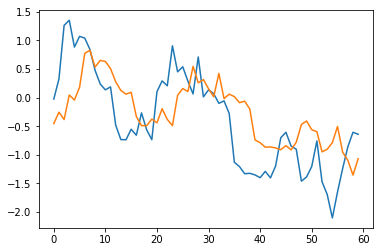

In [24]:
y_LR = LR.predict(x_data)
plt.plot(y_data[:60])
plt.plot(y_LR[:60])

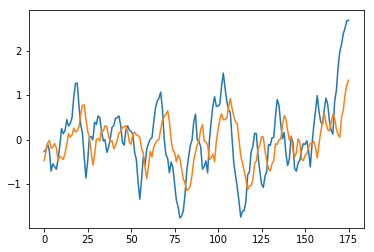

In [25]:
y_LR = LR.predict(x_test)
plt.plot(y_test)
plt.plot(y_LR)

The correlation is 0.526

In [26]:
np.corrcoef(y_LR,y_test)

array([[ 1.        ,  0.48443197],
       [ 0.48443197,  1.        ]])

### Bayesian Model
1. I start with a linear regression model but the coefficients and interception is computed based on the Bayesian model

Here I assume the Nino index is Gaussian distributed (actually it's not)

(array([  14.,   55.,  139.,  163.,  104.,   67.,   33.,   11.,    6.,    8.]),
 array([-2.10094921, -1.56429033, -1.02763144, -0.49097256,  0.04568632,
         0.58234521,  1.11900409,  1.65566297,  2.19232186,  2.72898074,
         3.26563963]),
 <a list of 10 Patch objects>)

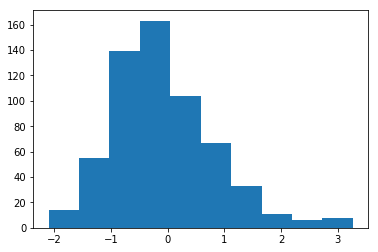

In [14]:
plt.hist(nino)

In [27]:
with pm.Model() as model:
    std = pm.Uniform("std", 0, .1)
    
    _nt, _k = x_data.shape
    
    beta = pm.Uniform("beta", -1, 1, shape=(1,_k))
    alpha = pm.Normal("alpha", mu=0, sd=.5, shape=1)
    
    #_mean = pm.Deterministic("_mean", np.zeros(_nt))
    #_mean = np.zeros(_nt)
    #for i in range(_nt):
    #    for j in range(_k):
    #        print(beta[j])
    #        print(x_data[i,j])
    #        _mean[i] += beta[j]*x_data[i,j]
    #for i in range(_nt):
    #    _mean[i] = alpha+[beta[j]*x_data[i,j] for j in range(_k)] # for i in range(_nt)
    _mean = alpha+beta*x_data
    
    mean = pm.Deterministic("mean", _mean.T) 
    obs = pm.Normal("obs", mu=mean, sd=std, observed=np.matlib.repmat(y_data, _k, 1))
    
    mu, sds, elbo = pm.variational.advi(n=50000)
    step = pm.NUTS(scaling=model.dict_to_array(sds), is_cov=True)
    samples = 2e4
    trace = pm.sample(samples, step=step, start=mu)
    
    #trace = pm.sample(100000, step=pm.Metropolis())
    burned_trace = trace[-1000:]

Average ELBO = -13,841: 100%|██████████| 50000/50000 [00:07<00:00, 6637.22it/s]   
Finished [100%]: Average ELBO = -13,841
100%|██████████| 20000/20000.0 [01:21<00:00, 244.10it/s]


In [33]:
LR.intercept_

-0.0051369916561481432

In [37]:
np.mean(burned_trace['beta'],axis=1)

array([[ 0.02944139,  0.02714591,  0.01583606,  0.00880898,  0.00141718,
         0.00541417,  0.0047314 , -0.00621021, -0.01319484, -0.00693586,
        -0.00550381, -0.00466004, -0.00366277, -0.00691302, -0.01432258,
        -0.0223694 , -0.02173118, -0.01958595, -0.03059392, -0.03311118,
        -0.03051459, -0.0274692 , -0.02300183, -0.01479035, -0.01000481,
        -0.00809246, -0.00769783,  0.00291168,  0.01933248,  0.03929567,
         0.06359749,  0.08959855,  0.11402165,  0.13599522,  0.15620987,
         0.17498161,  0.19029457,  0.20128565,  0.20057168,  0.19638518,
         0.18596674,  0.17201081,  0.1542493 ,  0.13447472,  0.1184215 ,
         0.10420859,  0.08956435,  0.07170405,  0.05815712,  0.03945409,
         0.02199515,  0.01219423,  0.00301042, -0.00903577, -0.03455563,
        -0.0644202 , -0.10350288, -0.14227949, -0.18583629, -0.22585912,
        -0.25610846, -0.28000134, -0.2975131 , -0.30683883, -0.31050432,
        -0.31380656, -0.31221625, -0.30707279, -0.2

In [38]:
LR.coef_

array([ 0.00769262,  0.09471398, -0.07545992,  0.01725889,  0.08295551,
       -0.05313084,  0.04572439, -0.0310463 , -0.09517152,  0.03724777,
       -0.02429036,  0.06264862,  0.06664126, -0.10909811,  0.08219448,
        0.0069473 , -0.03048419,  0.16885339, -0.07805914, -0.06586011,
        0.00182109, -0.04509086,  0.02755004,  0.033366  ,  0.06315233,
        0.02748412, -0.02028034, -0.00331695, -0.04356339,  0.00766347,
        0.00209276,  0.0110192 ,  0.04315794, -0.03095835,  0.01147214,
       -0.06422995,  0.04649863,  0.04413396, -0.03695696,  0.07643105,
       -0.02597551,  0.00693549, -0.02840843,  0.02943116, -0.04088656,
        0.03622752,  0.11730068, -0.03704588,  0.07573714, -0.11803259,
       -0.10661854, -0.09341034,  0.00206599,  0.00937389,  0.02544093,
        0.11877803, -0.03107203,  0.0484153 , -0.01031   , -0.06261705,
       -0.03986767,  0.03007785, -0.04792945, -0.02946683,  0.04253136,
       -0.09278418, -0.07101567, -0.03932846, -0.0378134 ,  0.00

NameError: name 'y_B' is not defined

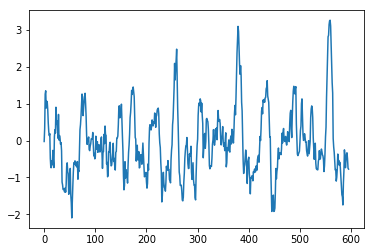

In [30]:
y_dataB = np.tensordot(np.mean(burned_trace['beta'], axis=0),x_data.T, axes=1)+np.mean(burned_trace['alpha'])
plt.plot(y_data[:])
plt.plot(y_B.T[:]/3)

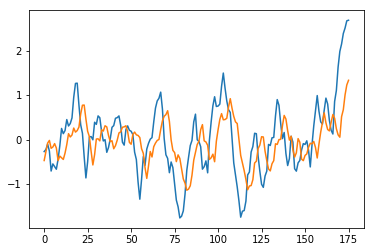

In [32]:
y_testB = np.tensordot(np.mean(burned_trace['beta'], axis=0),x_test.T, axes=1)+np.mean(burned_trace['alpha'])
plt.plot(y_test)
plt.plot(y_testB.T)

In [31]:
np.corrcoef(y_test,y_testB)

array([[ 1.        ,  0.17706814],
       [ 0.17706814,  1.        ]])

In [32]:
np.corrcoef(y_data, y_dataB)

array([[ 1.        ,  0.50898091],
       [ 0.50898091,  1.        ]])

The model just captures the trend but not the small features. And, for some weird reason, the magnitude is about 3 times higher than the observation. We need to know why.

In [16]:
x_data.shape[0]
burned_trace = trace[-1000:]

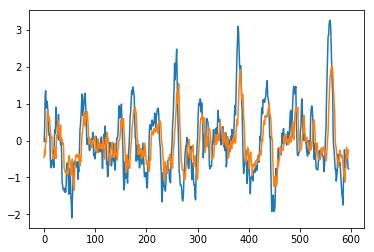

In [35]:
#figsize(12.5, 6)
from scipy.optimize import fmin


def nino_loss(obs, pred, coef = 1):
    """vectorized for numpy"""
    los = np.zeros_like(obs)
    xobs = abs(obs)-.5  # we are particularly interested in El Nino and La Nina events
    ypred = abs(pred)-.5
    ix = xobs*ypred < 0 # if El Nino or La Nina happens but the prediction fails or vice versa
    los[ix] = coef*abs(obs[ix] - pred)**2
    los[~ix] = abs(obs[~ix] - pred)**2
    return los

std_samples = burned_trace["std"]
alpha_samples = burned_trace["alpha"]
beta_samples = burned_trace["beta"]

N = std_samples.shape[0]

noise = std_samples*np.random.randn(N) 

possible_outcomes = lambda signal: alpha_samples + np.dot(beta_samples,signal) + noise

N_p = x_data.shape[0]
opt_predictions = np.zeros(N_p)
obs_signals = x_data
#obs_signals =  np.linspace(x_data.min(), x_data.max(), N_p)
for i, _signal in enumerate(obs_signals):
        _possible_outcomes = possible_outcomes(_signal)
        tomin = lambda pred: nino_loss(_possible_outcomes, pred).mean()
        opt_predictions[i] = fmin(tomin, 0, disp = False)
        
        
#plt.xlabel("observation")
#plt.ylabel("prediction")
#plt.title("Least-squares prediction vs. Bayes action prediction")
#plt.plot(x_data, LR.coef_*x_data + LR.intercept_, label ="Least-squares prediction")
#plt.xlim(x_data.min(), x_data.max())
#plt.plot(trading_signals, opt_predictions, label ="Bayes action prediction")
#plt.legend(loc="upper left");
#plt.scatter(x_data, y_data)
plt.plot(y_data)
plt.plot(opt_predictions)

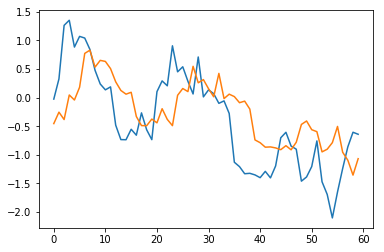

In [37]:
plt.plot(y_data[:60])
plt.plot(opt_predictions[:60])

In [36]:
np.corrcoef(opt_predictions,y_data)

array([[ 1.        ,  0.63168931],
       [ 0.63168931,  1.        ]])

In [53]:
_signal.shape

(84,)

In [57]:
alpha_samples.shape

(10000, 1)

In [ ]:
np.dot(beta_samples[:,0,:],_signal).shape

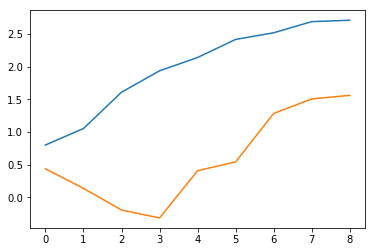

In [49]:
nt = 60
x_test = np.zeros([nt-3-k,k])

for i in range(nt-3-k):
    x_test[i, :] = np.array(nino_test[i:i+k])
y_test = np.array(nino_test[k+3:])
y_lr = LR.predict(x_test)
plt.plot(y_test)
plt.plot(y_lr)

In [ ]:
y_lr.shape

In [ ]:
pca.components_.shape

In [ ]:
# test case with just nino index
import pymc3 as pm

k=3
nt, ny, nx = anom20.shape
x_data = np.zeros([nt-k,nEOF])

#for i in range(nt-k):
#    x_data[i, :] = np.array(pca.components_)
x_data = pca.components_[:,:nt-k].T #.reshape(-1,1)
y_data = np.array(nino[k:])

LR = sk.linear_model.LinearRegression()
LR.fit(x_data, y_data)
#LR.fit([np.array([x_data[i:i+12] for i in range(nt-3)]),
#        [y_data[j] for j in range(nt-3)])

#LR.fit(x_data, y_data)

In [ ]:
y_LR = LR.predict(x_data[:50,:])
plt.plot(y_data[:50])
plt.plot(y_LR)

In [ ]:
# the occurrence of El Nino events

occurrence = np.zeros_like(nino)

for i in range(nt-5):
    if np.all(nino[i:i+5]>.5):
        occurrence[i] = 1

plt.scatter(range(nt),occurrence)